In [1]:
import numpy as np # import numpy untuk manipulasi data numerik
import tensorflow_datasets as tfds # import tensorflow untuk mengunduh, memuat, dan memanipulasi dataset dalam format yg sesuai
import tensorflow as tf # untuk membangun, melatih, dan menerapkan model machine learning

tfds.disable_progress_bar() # untuk menonaktifkan tampilan bar progres yang biasanya ditampilkan saat mengunduk dataset

c:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import matplotlib.pyplot as plt # untuk membuat visualisasi grafik dalam python

def plot_graphs(history, metric): # deklarasi fungsi plot_graph
    plt.plot(history.history[metric]) # menggunakan fungsi plt.plot() dari pustaka matplotlib untuk membuat garis grafik dari nilai metrik pelatihan
    plt.plot(history.history['val_'+metric], '') # untuk membuat garis grafik dari nilai metrik validasi
    plt.xlabel("Epochs") # untuk menetapkan label sumbu x pada grafik dengan nama "epochs"
    plt.ylabel(metric) # untuk menetapkan label sumbu y pada grafik sesuai dengan metrik yang diberikan sebagai argumen
    plt.legend([metric, 'val_'+metric]) # untuk menampilkan legenda pada grafik


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True) # memuat dataset dalam bentuk pasangan data latih dan label
train_dataset, test_dataset = dataset['train'], dataset['test'] # membagi dataset yang dimuat menjadi 2 bagian

train_dataset.element_spec # untuk mengetahui spesifikasi elemen dalam dataset pelatihan  

Dataset imdb_reviews downloaded and prepared to C:\Users\ASUS\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1): # untuk mengambil satu elemen dari dataset pelatihan
  print('text: ', example.numpy()) # mencetak teks ulasan dari contoh
  print('label: ', label.numpy()) # mengonversi tensor label menjadi representasi numpy array agar dapat dicetak

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000 # untuk menetukan ukuran buffer pengacakan dataset pelatihan
BATCH_SIZE = 64 # untuk menentukan ukuran batch dalam pelatihan dan pengujian

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # menerapkan beberapa transformasi pada dataset pelatihan
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # menerapkan transformasi pada dataset pengujian

# mengambil satu batch dari dataset pelatihan
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I guess I have still enough brain left to NOT find this movie funny. -Great comedians - but a very poor movie! The "best" performance still did NINA HAGEN <br /><br />TRIVIA: Did you realize that it the "real world" scenes (in Hamburg) the cars are almost ONLY new BMWs ?? <br /><br />I guess I have still enough brain left to NOT find this movie funny. -Great comedians - but a very poor movie! The "best" performance still did NINA HAGEN <br /><br />TRIVIA: Did you realize that it the "real world" scenes (in Hamburg) the cars are almost ONLY new BMWs ??'
 b"First of all, I have to start this comment by saying I'm a huge Nightmare on Elm Street fan. I think it's the greatest horror series ever. For me, Freddy is the boogeyman! Of course, Freddy's Dead, which tried to be the last chapter back then, is a weird movie. It doesn't have the same atmosphere than the previous films. Freddy has a lot of screen time. Some think it makes him less scary, which I do agree. And that's, in my

In [6]:
VOCAB_SIZE = 1000 # menunjukkan jumlah maksimum token unik yang akan dipertahankan dalam representasi vektor
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE) # membuat objek untuk mengubah teks menjadi representasi vektor
encoder.adapt(train_dataset.map(lambda text, label: text)) # untuk menyesuaikan layer dengan data pelatihan

In [7]:
vocab = np.array(encoder.get_vocabulary()) # untuk mengambil kamus token yang telah dibangun dan mengembalikan daftar token dalam urutan frekuensi
vocab[:20] # mencetak 20 elemen pertama dari array vocab


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy() # mengonversi teks example menjadi representasi vektor menggunakan kamus token yang telah dibangun oleh layer encoder
encoded_example # sebagai input untuk model

array([[ 10, 479,  10, ...,   0,   0,   0],
       [ 86,   5,  32, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0]], dtype=int64)

In [9]:
for n in range(3): # looping berjalan sebanyak 3 kali
  print("Original: ", example[n].numpy()) # mencetak teks asli yg digunakan untuk mengonversi tensor menjadi array numpy 
  print("Round-trip: ", " ".join(vocab[encoded_example[n]])) # mencetak hasil kembalian dari representasi vektor encoded_example
  print() # mencetak baris kosong antara setiap contoh teks

Original:  b'I guess I have still enough brain left to NOT find this movie funny. -Great comedians - but a very poor movie! The "best" performance still did NINA HAGEN <br /><br />TRIVIA: Did you realize that it the "real world" scenes (in Hamburg) the cars are almost ONLY new BMWs ?? <br /><br />I guess I have still enough brain left to NOT find this movie funny. -Great comedians - but a very poor movie! The "best" performance still did NINA HAGEN <br /><br />TRIVIA: Did you realize that it the "real world" scenes (in Hamburg) the cars are almost ONLY new BMWs ??'
Round-trip:  i guess i have still enough [UNK] left to not find this movie funny great [UNK] but a very poor movie the best performance still did [UNK] [UNK] br br [UNK] did you realize that it the real world scenes in [UNK] the [UNK] are almost only new [UNK] br br i guess i have still enough [UNK] left to not find this movie funny great [UNK] but a very poor movie the best performance still did [UNK] [UNK] br br [UNK] did 

In [10]:
model = tf.keras.Sequential([
    encoder, # untuk mengubah teks menjadi representasi vektor 
    tf.keras.layers.Embedding( # lapisan embedding yang mengambil representasi vektor hasil dari encoder sebagai input
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # untuk memproses urutan masukan dari lapisan sebelumnya
    tf.keras.layers.Dense(64, activation='relu'), # memperkenalkan non-lineritas ke dalam model
    tf.keras.layers.Dense(1) # sebagai lapisan output untuk tugas klasifikasi sentimen biner
])

In [11]:
print([layer.supports_masking for layer in model.layers]) # mencetak daftar boolean 

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.') # teks yang akan diprediksi sentimennya
predictions = model.predict(np.array([sample_text])) # melakukan prediksi sentimen pada contoh teks
print(predictions[0]) # mencetak hasil prediksi dari contoh teks

1/1 [==============================] - 4s 4s/step
[-0.00475443]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000 # untuk menjaga panjang contoh teks agar sama dengan panjang maksimum
predictions = model.predict(np.array([sample_text, padding])) # melakukan prediksi sentimen pada dua contoh teks
print(predictions[0]) # mencetak hasil prediksi sentimen dari contoh teks pertama

1/1 [==============================] - 0s 322ms/step
[-0.00475443]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # mengatur fungsi kerugian yang digunakan saat melatih model
              optimizer=tf.keras.optimizers.Adam(1e-4), # mengatur optimizer yang digunakan saat melatih model
              metrics=['accuracy']) # mengatur metrik evaluasi

In [15]:
history = model.fit(train_dataset, epochs=10, # menentukan jumlah epoch yang akan digunakan saat melatih model
                    validation_data=test_dataset, # menentukan dataset validasi yang kaan digunakan untuk evaluasi model setiap epoch
                    validation_steps=30) # menentukan jumlah langkah validasi yang harus di eksekusi setiap epoch

Epoch 1/10


391/391 [==============================] - 3445s 9s/step - loss: 0.6608 - accuracy: 0.5441 - val_loss: 0.4886 - val_accuracy: 0.7521
Epoch 2/10
391/391 [==============================] - 1873s 5s/step - loss: 0.4501 - accuracy: 0.7798 - val_loss: 0.3880 - val_accuracy: 0.8234
Epoch 3/10
391/391 [==============================] - 10481s 27s/step - loss: 0.3651 - accuracy: 0.8376 - val_loss: 0.3503 - val_accuracy: 0.8417
Epoch 4/10
391/391 [==============================] - 1775s 5s/step - loss: 0.3325 - accuracy: 0.8549 - val_loss: 0.3346 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 1321s 3s/step - loss: 0.3184 - accuracy: 0.8619 - val_loss: 0.3264 - val_accuracy: 0.8625
Epoch 6/10
391/391 [==============================] - 1426s 4s/step - loss: 0.3084 - accuracy: 0.8671 - val_loss: 0.3216 - val_accuracy: 0.8651
Epoch 7/10
391/391 [==============================] - 1411s 4s/step - loss: 0.3046 - accuracy: 0.8705 - val_loss: 0.3206 - val_accuracy: 0.8578
E

In [25]:
test_loss, test_acc = model.evaluate(test_dataset) # menyimpan nilai loss yang dihasilkan evaluasi pada dataset uji

print('Test Loss:', test_loss) # mencetak nilai loss 
print('Test Accuracy:', test_acc) # mencetak nilai akurasi

391/391 [==============================] - 639s 2s/step - loss: 0.3342 - accuracy: 0.8637
Test Loss: 0.3341790735721588
Test Accuracy: 0.8637199997901917


(0.0, 0.6790584191679955)

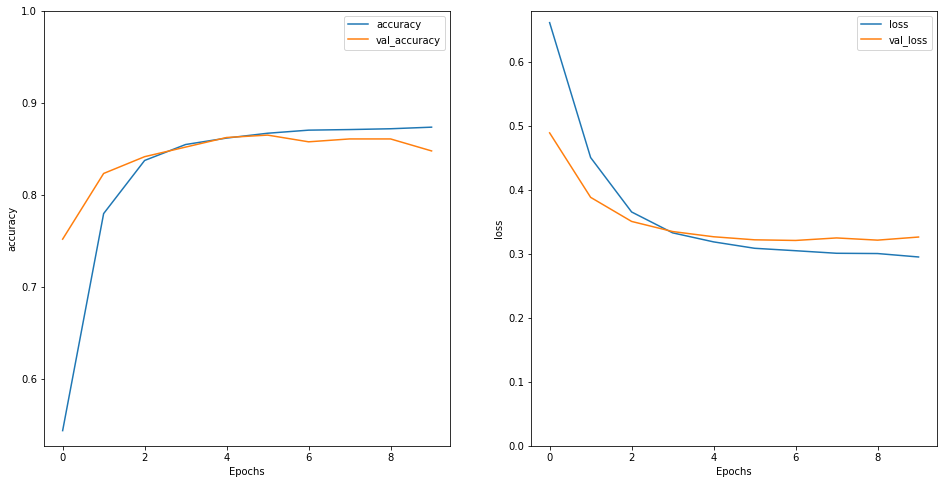

In [17]:
plt.figure(figsize=(16, 8)) # untuk membuat gambar dengan
plt.subplot(1, 2, 1) # untuk membuat subplot pertama
plot_graphs(history, 'accuracy') # untuk memanggil fungsi plot_graphs
plt.ylim(None, 1) # untuk mengatur batas sumbu
plt.subplot(1, 2, 2) # untuk membuat subplot kedua dengan rasio lebar-tinggi 1:2
plot_graphs(history, 'loss') # akan menghasilkan plot grafik untuk melihat perubahan loss selama pelatihan model
plt.ylim(0, None) # untuk mengatur batas sumbu y pada subplot kedua

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
              'were out of this world. I would recommend this movie.') # teks yang ingin di prediksi
predictions = model.predict(np.array([sample_text])) # melakukan prediksi sentimen pada contoh teks yang diberikan

1/1 [==============================] - 4s 4s/step


In [19]:
model = tf.keras.Sequential([ # membuat objek model yang digunakan untuk tugas pengolahan bahasa alami
    encoder, # layer pertama dalam model dan digunakan untuk mengonversi teks menjadi representasi numerik
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True), # mengubah representasi nukerik dari kata menjadi vektor
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # model untuk mempelajari pola dari kedua arah 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(64, activation='relu'), # layer yang menghubungkan output dari layer sebelumnya ke output yang terakhir
    tf.keras.layers.Dropout(0.5), # digunakan untuk mengurangi overfitting dengan secara acak
    tf.keras.layers.Dense(1) # sebagai output layer yang menghasilkan prediksi sentimen
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # mengatur fungsi loss yang akan digunakan selama pelatihan model
              optimizer=tf.keras.optimizers.Adam(1e-4), # mengoptimalkan parameter model untu mengurangi loss
              metrics=['accuracy']) # menentukan metrik evaluasi yg digunakan untuk mengukur sejauh mana model 

In [21]:
history = model.fit(train_dataset, epochs=10, # melatih model
                    validation_data=test_dataset, # menentukan dataset validasi yang akan digunakan selama pelatihan
                    validation_steps=30) # menentukan jumlah langkah evaluasi yang akan dilakukan pada dataset validasi

Epoch 1/10


391/391 [==============================] - 2720s 7s/step - loss: 0.6244 - accuracy: 0.5994 - val_loss: 0.4505 - val_accuracy: 0.8026
Epoch 2/10
391/391 [==============================] - 2154s 6s/step - loss: 0.3907 - accuracy: 0.8317 - val_loss: 0.3510 - val_accuracy: 0.8505
Epoch 3/10
391/391 [==============================] - 2491s 6s/step - loss: 0.3345 - accuracy: 0.8603 - val_loss: 0.3321 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 2232s 6s/step - loss: 0.3232 - accuracy: 0.8624 - val_loss: 0.3291 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 2032s 5s/step - loss: 0.3137 - accuracy: 0.8668 - val_loss: 0.3312 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 2231s 6s/step - loss: 0.3049 - accuracy: 0.8722 - val_loss: 0.3247 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 4313s 11s/step - loss: 0.3014 - accuracy: 0.8698 - val_loss: 0.3252 - val_accuracy: 0.8448
Ep

In [22]:
test_loss, test_acc = model.evaluate(test_dataset) # evaluasi model pada dataset uji dan akan menghitung loss dan metrik yang telah ditentukan

print('Test Loss:', test_loss) # variabel yang akan menampung nilai loss dan akurasi 
print('Test Accuracy:', test_acc) # mencetak nilai akurasi pada dataset

391/391 [==============================] - 595s 2s/step - loss: 0.3342 - accuracy: 0.8637
Test Loss: 0.3341790735721588
Test Accuracy: 0.8637199997901917


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.') # contoh teks
predictions = model.predict(np.array([sample_text])) # melakukan prediksi sentimen pada contoh teks yang diberikan
print(predictions) # mencetak hasil prediksi

1/1 [==============================] - 16s 16s/step
[[-1.7134913]]


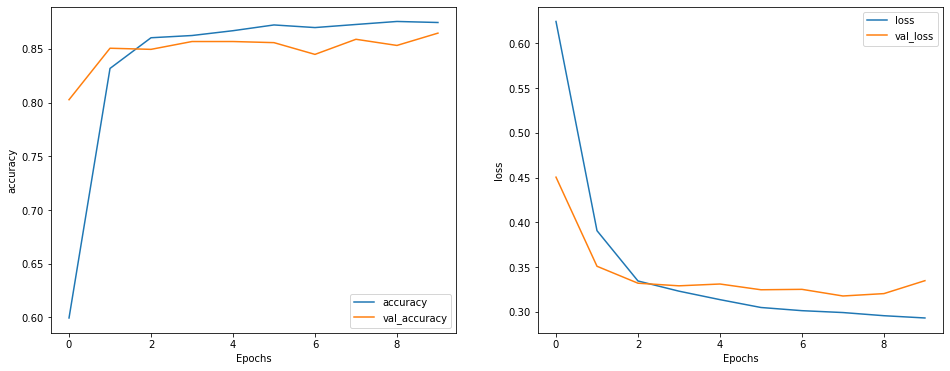

In [24]:
plt.figure(figsize=(16, 6)) # membuat sebuah figur dengan ukuran 16x6
plt.subplot(1, 2, 1) # membuat subplot pertama dengan konfigurasi 1 baris dan 2 kolom
plot_graphs(history, 'accuracy') # memanggil fungsi untuk menggambar grafik akurasi
plt.subplot(1, 2, 2) # membuat subplot kedua dengan konfigurasi 1 baris dan 2 kolom
plot_graphs(history, 'loss') # memanggil fungsi plot_graphs untuk menggambar grafik loss